In [3]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [30]:
def FilterDF(df, cols_keep, date_col, class_col, filter_criteria={}, start_year=2000, end_year=2020):

    # Ensure Correct Data Types
    if type(cols_keep) != list:
        cols_keep = [cols_keep]

    # Extract Desired Columns
    df_clean = df[cols_keep].copy()
    
    # Convert Date Column to DateTime
    df_clean[date_col] = pd.to_datetime(df_clean[date_col])

    # Filter Date Column To Desired Range (2000-2020 defualt)
    df_clean = df_clean.loc[(df_clean[date_col].dt.year >= start_year) & 
                            (df_clean[date_col].dt.year <= end_year)]

    # Filter Anything Not Needed
    if filter_criteria != {}:
        for key in filter_criteria.keys():
            df_clean = df_clean.loc[df_clean[key] == filter_criteria[key]]

    # Filter Class Type != Savings or Commercial
    df_clean = df_clean.loc[(df_clean[class_col] == 'Savings') |
                            (df_clean[class_col] == 'Commercial')
                            ].reset_index(drop=True)

    

    return df_clean


ni2 = FilterDF(new_institutions, ['CERT', 'FRM_CLASS_TYPE_DESC', 'EFFDATE'], 'EFFDATE', 'FRM_CLASS_TYPE_DESC')
li2 = FilterDF(liquidations, ['CERT', 'FRM_CLASS_TYPE_DESC', 'EFFDATE', 'CHANGECODE_DESC'], 'EFFDATE', 
         'FRM_CLASS_TYPE_DESC', filter_criteria={'CHANGECODE_DESC': 'FINANCIAL DIFFICULTY - PAYOFF'})
co2 = FilterDF(combinations, ['CERT', 'ACQ_CLASS_TYPE_DESC', 'EFFDATE'], 'EFFDATE', 'ACQ_CLASS_TYPE_DESC')
fa2 = FilterDF(failures, ['CERT', 'ACQ_CLASS_TYPE_DESC', 'EFFDATE'], 'EFFDATE', 'ACQ_CLASS_TYPE_DESC')


In [31]:
def CountByYear(df, class_col, date_col, count_col):

    # Count Cert IDs by Year
    df_by_year = df.groupby([class_col, df[date_col].dt.year]).count()[count_col].reset_index()
    df_by_year.columns = ['Class Type', 'Year', 'Count']

    # Fill in Missing Years
    for year in range(2000, 2021):
        temp_com = df_by_year.loc[(df_by_year['Year'] == year) &
                                  (df_by_year['Class Type'] == 'Commercial')]
        temp_sav = df_by_year.loc[(df_by_year['Year'] == year) &
                                  (df_by_year['Class Type'] == 'Savings')]
        if len(temp_com) != 1:
            df_by_year = df_by_year.append({'Class Type': 'Commercial', 'Year': year, 'Count': 0}, ignore_index=True)
        if len(temp_sav) != 1:
            df_by_year = df_by_year.append({'Class Type': 'Savings', 'Year': year, 'Count': 0}, ignore_index=True)

    # Sort DataFrame
    df_by_year = df_by_year.sort_values(by=['Class Type', 'Year']).reset_index(drop=True)

    # Reformat DataFrame
    df_by_year_reformat = pd.DataFrame(df_by_year.loc[df_by_year['Class Type'] == 'Commercial', 'Year'])
    df_by_year_reformat['Commercial'] = list(df_by_year.loc[df_by_year['Class Type'] == 'Commercial', 'Count'])
    df_by_year_reformat['Savings'] = list(df_by_year.loc[df_by_year['Class Type'] == 'Savings', 'Count'])

    return df_by_year_reformat


ni2_cnts = CountByYear(ni2, 'FRM_CLASS_TYPE_DESC', 'EFFDATE', 'CERT')
li2_cnts = CountByYear(li2, 'FRM_CLASS_TYPE_DESC', 'EFFDATE', 'CERT')
co2_cnts = CountByYear(co2, 'ACQ_CLASS_TYPE_DESC', 'EFFDATE', 'CERT')
fa2_cnts = CountByYear(fa2, 'ACQ_CLASS_TYPE_DESC', 'EFFDATE', 'CERT')


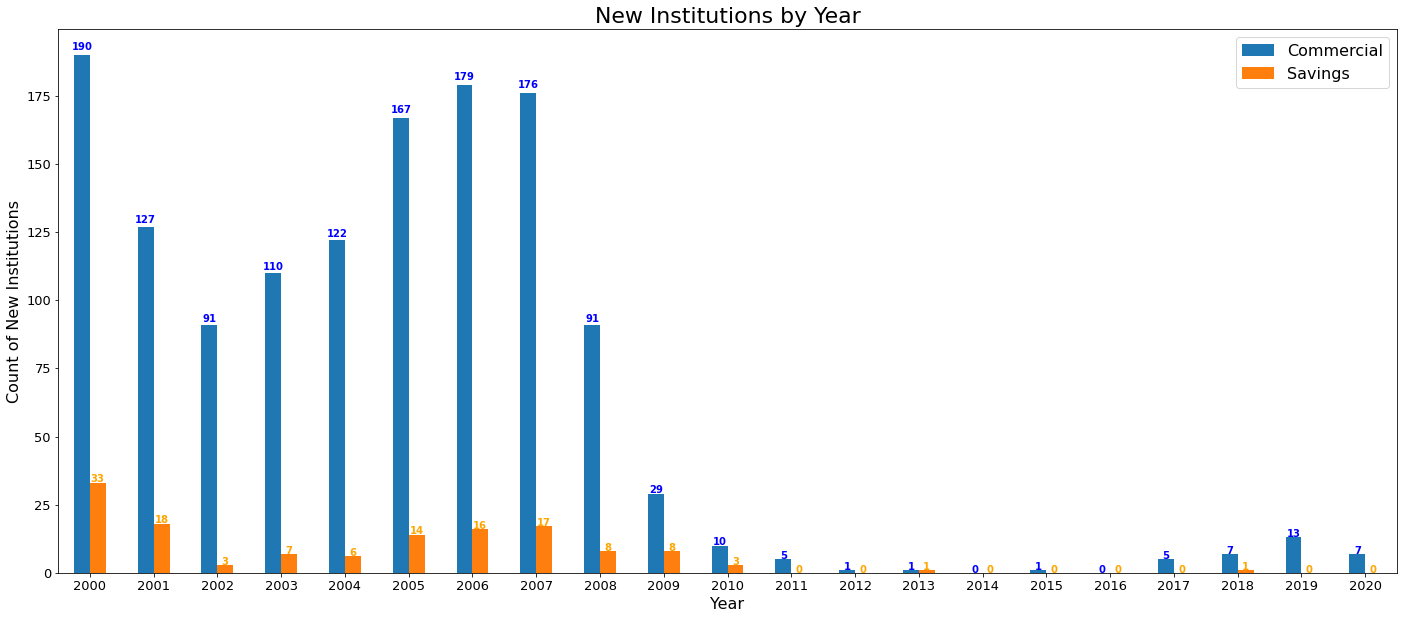

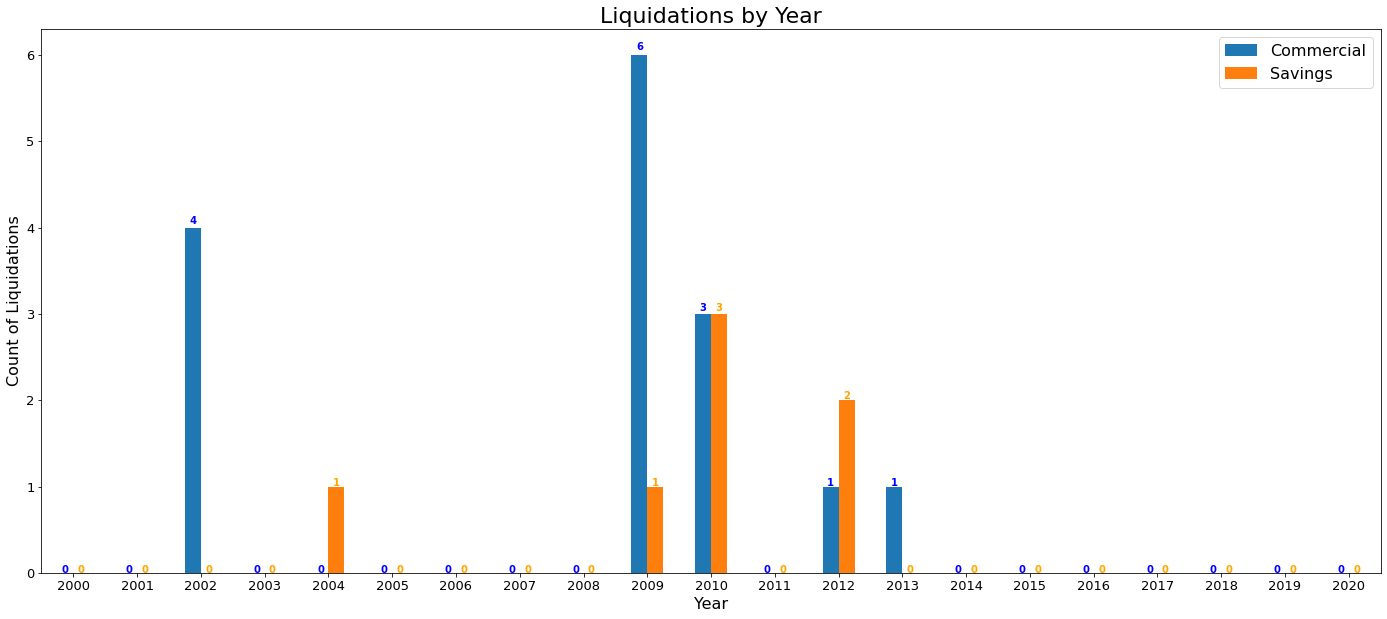

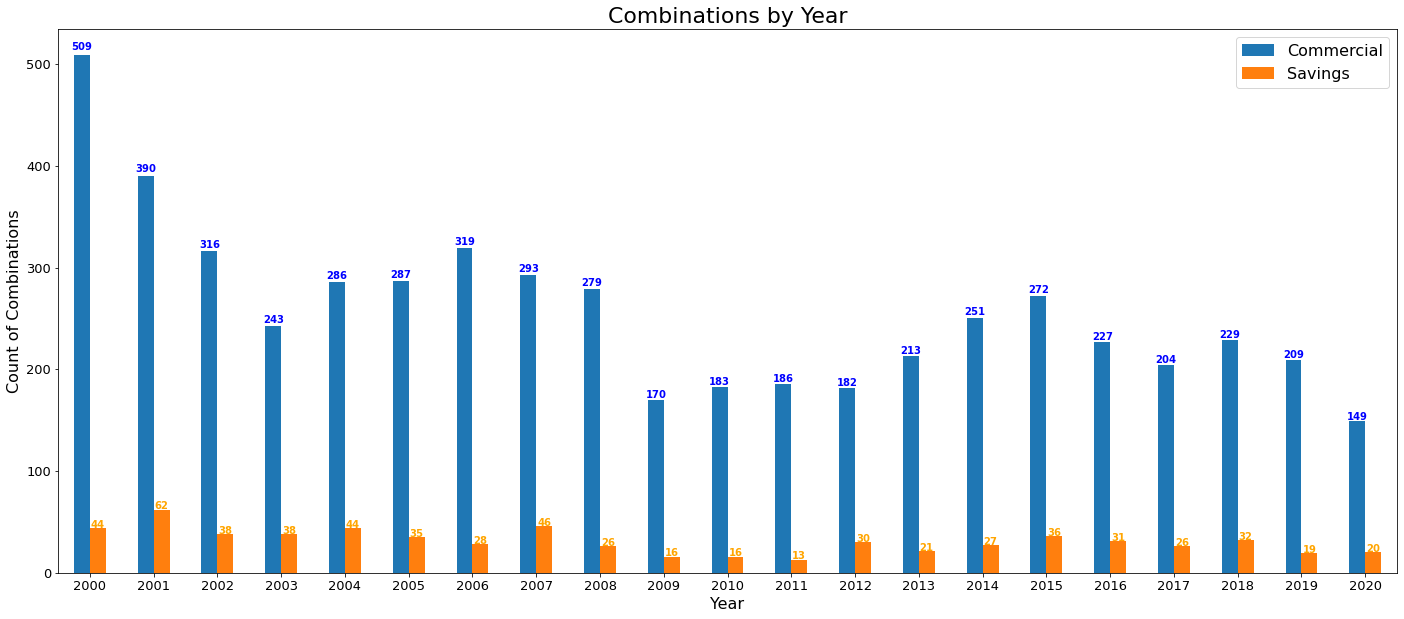

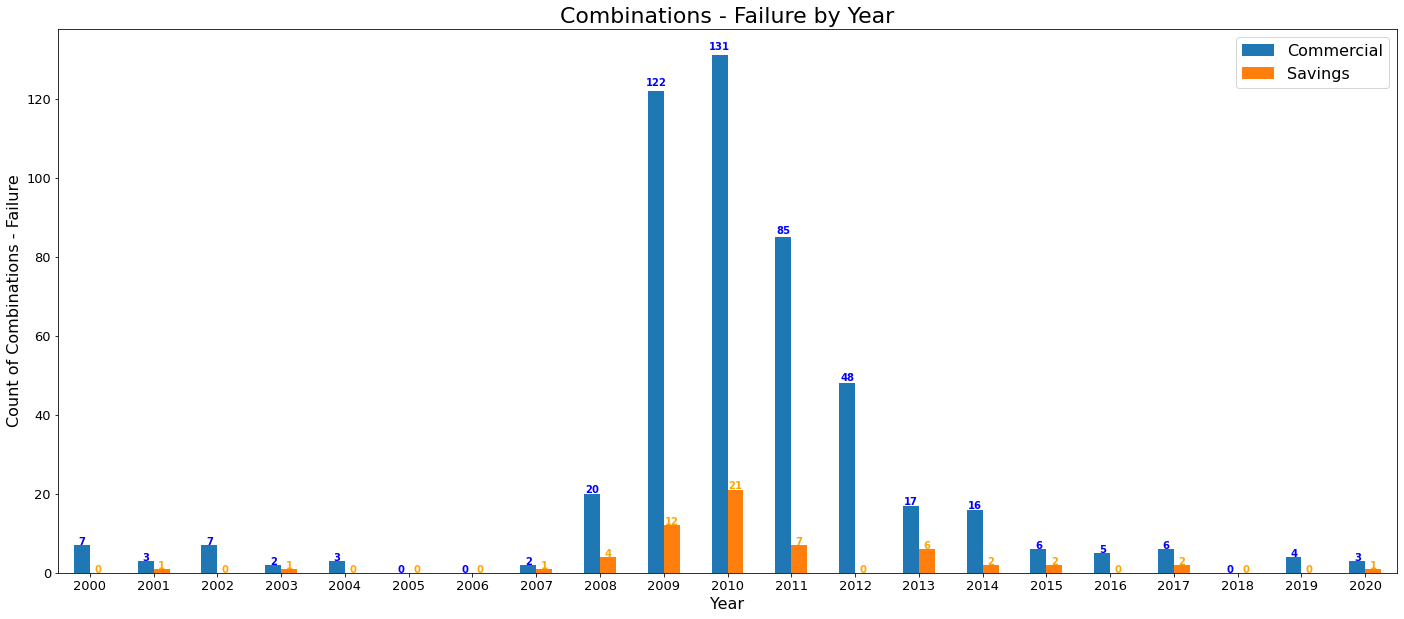

In [32]:
def GenerateHistogram(df, category, start_year=2000, end_year=2020):
    
    # Generate Figure
    fig, axis = plt.subplots(figsize=(24, 10))

    # Filter Year to Desired Time Frame
    df = df.loc[(df['Year'] >= start_year) & (df['Year'] <= end_year)
               ].reset_index(drop=True).copy()

    # Plot
    df.plot(kind='bar', x='Year', ax=axis)

    # Label Plot
    axis.set_ylabel(f'Count of {category}', size=16)
    axis.set_xlabel('Year', size=16)
    axis.set_title(f'{category} by Year', size=22)
    axis.tick_params(axis='x', labelsize=13, labelrotation=0)
    axis.tick_params(axis='y', labelsize=13)
    axis.legend(fontsize=16)

    # Write Counts Above Bars
    for i, v in enumerate(df['Commercial']):
        axis.text(i-0.123, 1.01*v, str(v), color='blue', fontweight='bold', horizontalalignment='center')
    for i, v in enumerate(df['Savings']):
        axis.text(i+0.123, 1.01*v, str(v), color='orange', fontweight='bold', horizontalalignment='center')

    # Show Figure
    fig.show()

GenerateHistogram(ni2_cnts, 'New Institutions')
GenerateHistogram(li2_cnts, 'Liquidations')
GenerateHistogram(co2_cnts, 'Combinations')
GenerateHistogram(fa2_cnts, 'Combinations - Failure')

In [62]:
def CombineChangesByYear(summary_com, summary_sav, new_institutions, conversions, conversions_failed, liquidations, combine=False):

    if combine:

        data = []
        for year in range(2000, 2021):

            # Generate the total counts for each year
            total_start = int(summary_com[summary_com['YEAR'] == year]['Total']) + \
                             int(summary_sav[summary_sav['YEAR'] == year]['Total'])
            total_ni = int(new_institutions[new_institutions['Year'] == year]['Commercial']) + \
                         int(new_institutions[new_institutions['Year'] == year]['Savings'])
            total_co = int(conversions[conversions['Year'] == year]['Commercial']) + \
                         int(conversions[conversions['Year'] == year]['Savings'])
            total_fa = int(conversions_failed[conversions_failed['Year'] == year]['Commercial']) + \
                         int(conversions_failed[conversions_failed['Year'] == year]['Savings'])
            total_li = int(liquidations[liquidations['Year'] == year]['Commercial']) + \
                         int(liquidations[liquidations['Year'] == year]['Savings'])

            # Put counts into individual rows
            data_year = [
                [f'{year} Total', total_start, 'Absolute', 'Year Start'],
                ['New Institutions', total_ni, 'Relative', 'New Institutions'],
                ['Combinations', -total_co, 'Relative', 'Combinations'], 
                ['Combinations - Failed', -total_fa, 'Relative', 'Combinations of Failed Bank'], 
                ['Liquidations', -total_li, 'Relative', 'Liquidations'], 
                        ]

            # Add year to aggregate data
            data.extend(data_year)

        # Create DataFrame with event counts by year
        df = pd.DataFrame(columns = ['Category', 'Value', 'Measure Type', 'Text'], data = data)
            
        return df

    else:

        data_com, data_sav = [], []
        for year in range(2000, 2021):

            # Generate the total counts for each year
            total_start_com = int(summary_com[summary_com['YEAR'] == year]['Total'])
            total_start_sav = int(summary_sav[summary_sav['YEAR'] == year]['Total'])
            total_ni_com = int(new_institutions[new_institutions['Year'] == year]['Commercial'])
            total_ni_sav = int(new_institutions[new_institutions['Year'] == year]['Savings'])
            total_co_com = int(conversions[conversions['Year'] == year]['Commercial'])
            total_co_sav = int(conversions[conversions['Year'] == year]['Savings'])
            total_fa_com = int(conversions_failed[conversions_failed['Year'] == year]['Commercial'])
            total_fa_sav = int(conversions_failed[conversions_failed['Year'] == year]['Savings'])
            total_li_com = int(liquidations[liquidations['Year'] == year]['Commercial'])
            total_li_sav = int(liquidations[liquidations['Year'] == year]['Savings'])

            # Put counts into individual rows
            data_year_com = [
                [f'{year} Total', total_start_com, 'Absolute', 'Year Start'],
                ['New Institutions', total_ni_com, 'Relative', 'New Institutions'],
                ['Combinations', -total_co_com, 'Relative', 'Combinations'], 
                ['Combinations - Failed', -total_fa_com, 'Relative', 'Combinations of Failed Bank'], 
                ['Liquidations', -total_li_com, 'Relative', 'Liquidations'], 
                        ]
            data_year_sav = [
                [f'{year} Total', total_start_sav, 'Absolute', 'Year Start'],
                ['New Institutions', total_ni_sav, 'Relative', 'New Institutions'],
                ['Combinations', -total_co_sav, 'Relative', 'Combinations'], 
                ['Combinations - Failed', -total_fa_sav, 'Relative', 'Combinations of Failed Bank'], 
                ['Liquidations', -total_li_sav, 'Relative', 'Liquidations'], 
                        ]

            # Add year to aggregate data
            data_com.extend(data_year_com)
            data_sav.extend(data_year_sav)

        # Create DataFrame with event counts by year
        df_com = pd.DataFrame(columns = ['Category', 'Value', 'Measure Type', 'Text'], data = data_com)
        df_sav = pd.DataFrame(columns = ['Category', 'Value', 'Measure Type', 'Text'], data = data_sav)

        return df_com, df_sav

waterfall_df_all = CombineChangesByYear(commercial_banks_sum, savings_institutions_sum, ni2_cnts, co2_cnts, fa2_cnts, li2_cnts, True)
waterfall_df_com, waterfall_df_sav =  CombineChangesByYear(commercial_banks_sum, savings_institutions_sum, ni2_cnts, co2_cnts, fa2_cnts, li2_cnts, False)

waterfall_df_all.to_csv("../../data/WaterFall_Data_All.csv")
waterfall_df_com.to_csv("../../data/WaterFall_Data_Commercial.csv")
waterfall_df_sav.to_csv("../../data/WaterFall_Data_SavingsIns.csv")

## New Institutions

In [28]:
new_institutions = pd.read_csv("../../data/New_Institutions_10_21_2021.csv")
new_institutions

,ACQDATE,ACQYEAR,ASSISTED_PAYOUT_FLAG,BANK_INSURED,CERT,CHANGECODE,CHANGECODE_DESC,CHANGECODE_DESC_LONG,CHARTAGENT,CHARTER_COM_TO_OTHER_FLAG,...,FRM_CERT,FRM_CHARTAGENT,FRM_CNTYNAME,FRM_INSTNAME,FRM_ORGTYPE,FRM_PADDR,FRM_PCITY,FRM_PZIP5,FRM_PZIPREST,FRM_TRUST
0,1986-09-16T00:00:00,1986,0,N,45583,110,NEW INSTITUTION,Institution established but was not FDIC insur...,STATE,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-03-29T00:00:00,2006,0,Y,34619,110,NEW INSTITUTION,Institution established. Original name: ITS Ba...,STATE,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-03-29T00:00:00,2006,0,Y,35045,110,NEW INSTITUTION,Institution established. Original name: Bristo...,STATE,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-05-04T00:00:00,2000,0,Y,35417,110,NEW INSTITUTION,Institution established. Original name: TriSta...,STATE,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2002-12-31T00:00:00,2002,0,Y,35347,110,NEW INSTITUTION,Institution established. Original name: Nation...,OCC,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18136,2000-08-10T00:00:00,2000,0,Y,35061,110,NEW INSTITUTION,Institution established. Original name: Horizo...,STATE,0,...,35061.0,STATE,MANATEE,Horizon Bank,COMMERCIAL BANK,"3005 26TH STREET WEST, SUITE C",BRADENTON,34205.0,0.0,NaN
18137,2000-07-31T00:00:00,2000,0,Y,35240,110,NEW INSTITUTION,Institution established. Original name: The To...,STATE,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18138,2000-06-20T00:00:00,2000,0,Y,35173,110,NEW INSTITUTION,Institution established. Original name: Allian...,OCC,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18139,2000-01-02T00:00:00,2000,0,Y,35281,110,NEW INSTITUTION,Institution established. Original name: Benefi...,OTS,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
new_institutions_clean = new_institutions[['EFFYEAR', "CLASS_TYPE", 'CERT']]
new_institutions_clean = new_institutions_clean[new_institutions_clean['EFFYEAR']>1999]
new_by_year = new_institutions_clean.groupby(['CLASS_TYPE', 'EFFYEAR']).count()['CERT'].reset_index()

new_by_year.columns = ['Class Type', 'Effective Year', 'Count']

In [6]:
for year in range(2000, 2022):
    temp_com = new_by_year.loc[(new_by_year['Effective Year'] == year) &
                               (new_by_year['Class Type'] == 'C')]
    temp_sav = new_by_year.loc[(new_by_year['Effective Year'] == year) &
                               (new_by_year['Class Type'] == 'S')]
    if len(temp_com) != 1:
        new_by_year = new_by_year.append({'Class Type': 'C', 'Effective Year': year, 'Count': 0}, ignore_index=True)
    if len(temp_sav) != 1:
        new_by_year = new_by_year.append({'Class Type': 'S', 'Effective Year': year, 'Count': 0}, ignore_index=True)

new_by_year = new_by_year.sort_values(by=['Class Type', 'Effective Year']).reset_index(drop=True)

new_by_year_reformat = pd.DataFrame(new_by_year.loc[new_by_year['Class Type'] == 'C', 'Effective Year'])
new_by_year_reformat['Commercial'] = list(new_by_year.loc[new_by_year['Class Type'] == 'C', 'Count'])
new_by_year_reformat['Savings'] = list(new_by_year.loc[new_by_year['Class Type'] == 'S', 'Count'])
new_by_year_reformat

,Effective Year,Commercial,Savings
0,2000,190,33
1,2001,127,18
2,2002,91,3
3,2003,110,7
4,2004,122,6
5,2005,167,14
6,2006,179,16
7,2007,176,17
8,2008,91,8
9,2009,29,8


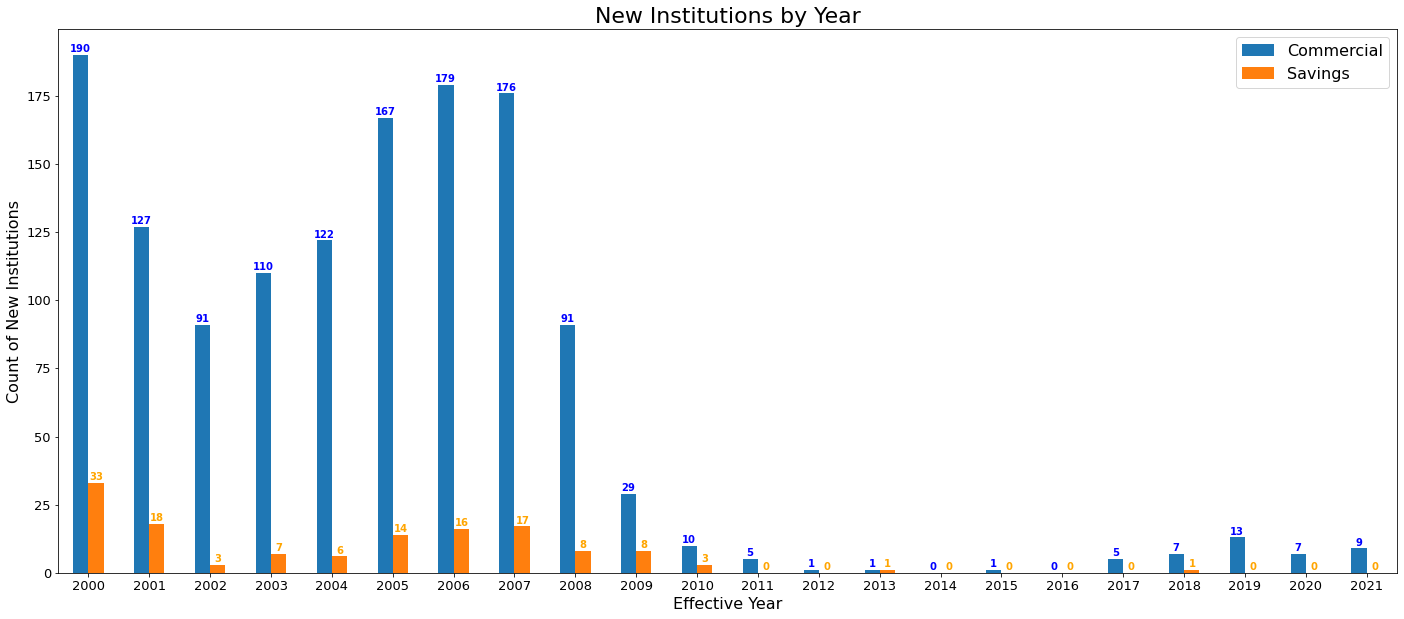

In [7]:
fig, axis = plt.subplots(figsize=(24, 10))

new_by_year_reformat.plot(kind='bar', x='Effective Year', ax=axis)

axis.set_ylabel('Count of New Institutions', size=16)
axis.set_xlabel('Effective Year', size=16)
axis.set_title('New Institutions by Year', size=22)

axis.tick_params(axis='x', labelsize=13, labelrotation=0)
axis.tick_params(axis='y', labelsize=13)

axis.legend(fontsize=16)

for i, v in enumerate(new_by_year_reformat['Commercial']):
    axis.text(i-0.13, v+1, str(v), color='blue', fontweight='bold', horizontalalignment='center')
for i, v in enumerate(new_by_year_reformat['Savings']):
    axis.text(i+0.13, v+1, str(v), color='orange', fontweight='bold', horizontalalignment='center')

fig.show()

## Liquidations

In [8]:
liquidations = pd.read_csv('../../data/Liquidations_10_21_2021.csv')

liquidations_clean = liquidations[['CERT', 'FRM_CLASS_TYPE_DESC', 'EFFDATE', 'PROCDATE', 'CHANGECODE_DESC']]
liquidations_clean['EFFDATE'] = pd.to_datetime(liquidations_clean['EFFDATE'])
liquidations_clean['PROCDATE'] = pd.to_datetime(liquidations_clean['PROCDATE'])

# Dropping those classified as 'OTHER LIQUIDATIONS AND CLOSINGS' or 'BANK CLOSED BY CHARTERING AGENT PENDING SALE'
# Only keep those classified 'FINANCIAL DIFFICULTY - PAYOFF'
liquidations_clean = liquidations_clean.loc[liquidations_clean['CHANGECODE_DESC'] == 
                        'FINANCIAL DIFFICULTY - PAYOFF'].reset_index(drop=True)

liquidations_clean

,CERT,FRM_CLASS_TYPE_DESC,EFFDATE,PROCDATE,CHANGECODE_DESC
0,22314,Commercial,2002-02-07,2002-02-08,FINANCIAL DIFFICULTY - PAYOFF
1,34979,Commercial,2002-03-28,2002-04-01,FINANCIAL DIFFICULTY - PAYOFF
2,33784,Commercial,2002-09-30,2002-10-04,FINANCIAL DIFFICULTY - PAYOFF
3,9961,Commercial,2002-11-08,2002-11-21,FINANCIAL DIFFICULTY - PAYOFF
4,31330,Savings,2004-02-14,2004-02-17,FINANCIAL DIFFICULTY - PAYOFF
5,58001,Commercial,2009-01-30,2009-01-30,FINANCIAL DIFFICULTY - PAYOFF
6,18243,Commercial,2009-03-20,2009-03-23,FINANCIAL DIFFICULTY - PAYOFF
7,32069,Commercial,2009-04-24,2009-04-27,FINANCIAL DIFFICULTY - PAYOFF
8,57436,Commercial,2009-06-26,2009-06-29,FINANCIAL DIFFICULTY - PAYOFF
9,35030,Savings,2009-09-04,2009-09-08,FINANCIAL DIFFICULTY - PAYOFF


In [9]:
liquidations_by_year = liquidations_clean.groupby(['FRM_CLASS_TYPE_DESC', pd.DatetimeIndex(liquidations_clean['EFFDATE']).year]).count()['CERT'].reset_index()
liquidations_by_year.columns = ['Class Type', 'Effective Year', 'Count']

liquidations_by_year

,Class Type,Effective Year,Count
0,Commercial,2002,4
1,Commercial,2009,6
2,Commercial,2010,3
3,Commercial,2012,1
4,Commercial,2013,1
5,Savings,2004,1
6,Savings,2009,1
7,Savings,2010,3
8,Savings,2012,2


In [10]:
for year in range(2000, 2022):
    temp_com = liquidations_by_year.loc[(liquidations_by_year['Effective Year'] == year) &
                                        (liquidations_by_year['Class Type'] == 'Commercial')]
    temp_sav = liquidations_by_year.loc[(liquidations_by_year['Effective Year'] == year) &
                                        (liquidations_by_year['Class Type'] == 'Savings')]
    if len(temp_com) != 1:
        liquidations_by_year = liquidations_by_year.append({'Class Type': 'Commercial', 'Effective Year': year, 'Count': 0}, ignore_index=True)
    if len(temp_sav) != 1:
        liquidations_by_year = liquidations_by_year.append({'Class Type': 'Savings', 'Effective Year': year, 'Count': 0}, ignore_index=True)

liquidations_by_year = liquidations_by_year.sort_values(by=['Class Type', 'Effective Year']).reset_index(drop=True)
liquidations_by_year = liquidations_by_year[liquidations_by_year['Effective Year'] >= 2000].reset_index(drop=True)

liquidations_by_year_reformat = pd.DataFrame(liquidations_by_year.loc[liquidations_by_year['Class Type'] == 'Commercial', 'Effective Year'])
liquidations_by_year_reformat['Commercial'] = list(liquidations_by_year.loc[liquidations_by_year['Class Type'] == 'Commercial', 'Count'])
liquidations_by_year_reformat['Savings'] = list(liquidations_by_year.loc[liquidations_by_year['Class Type'] == 'Savings', 'Count'])
liquidations_by_year_reformat

,Effective Year,Commercial,Savings
0,2000,0,0
1,2001,0,0
2,2002,4,0
3,2003,0,0
4,2004,0,1
5,2005,0,0
6,2006,0,0
7,2007,0,0
8,2008,0,0
9,2009,6,1


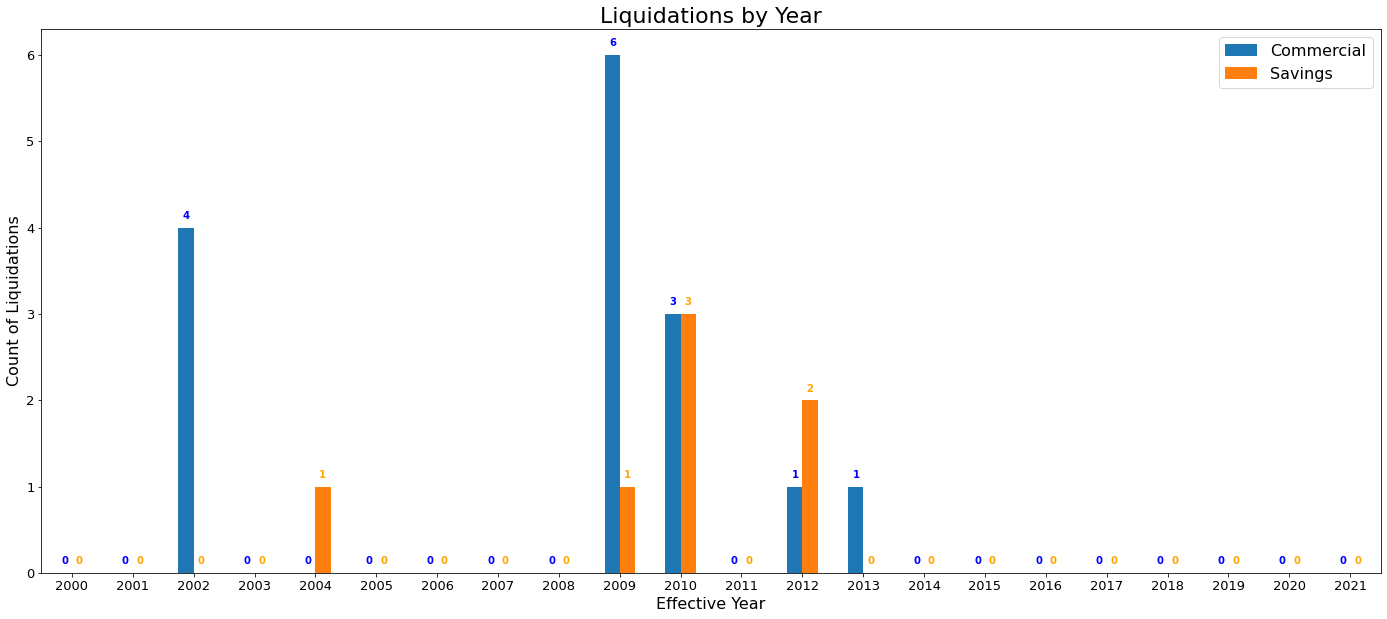

In [11]:
fig, axis = plt.subplots(figsize=(24, 10))

liquidations_by_year_reformat.plot(kind='bar', x='Effective Year', ax=axis)

axis.set_ylabel('Count of Liquidations', size=16)
axis.set_xlabel('Effective Year', size=16)
axis.set_title('Liquidations by Year', size=22)

axis.tick_params(axis='x', labelsize=13, labelrotation=0)
axis.tick_params(axis='y', labelsize=13)

axis.legend(fontsize=16)

for i, v in enumerate(liquidations_by_year_reformat['Commercial']):
    axis.text(i-0.12, v+0.1, str(v), color='blue', fontweight='bold', horizontalalignment='center')
for i, v in enumerate(liquidations_by_year_reformat['Savings']):
    axis.text(i+0.12, v+0.1, str(v), color='orange', fontweight='bold', horizontalalignment='center')

fig.show()

## Business Combinations

In [12]:
combinations = pd.read_csv('../../data/Business_Combinations_10_21_2021.csv')

combinations_clean = combinations[['CERT', 'ACQ_CLASS_TYPE_DESC', 'EFFDATE', 'PROCDATE', 'INSURED_OTS_FLAG']]
combinations_clean['EFFDATE'] = pd.to_datetime(combinations_clean['EFFDATE'])
combinations_clean['PROCDATE'] = pd.to_datetime(combinations_clean['PROCDATE'])


# Filter out INSURED_OTS_FLAG
# combinations_clean = combinations_clean.loc[combinations_clean['INSURED_OTS_FLAG'] == 0].reset_index(drop=True)

# # 7
# n = 14
# len(combinations.loc[(combinations['ACQ_CLASS_TYPE_DESC'] == 'Savings') &
#                  (combinations['INSURED_OTS_FLAG'] == 1) &
#                  (pd.DatetimeIndex(combinations['EFFDATE']).year >= 2000)&
#                  (pd.DatetimeIndex(combinations['EFFDATE']).year <= 2020),
#                 'EFFDATE'
#                 ].reset_index(drop=True).sort_values())

combinations_clean

# SPLIT -> with CBS  (227)
# FRM_CLASS_TYPE -> C                 |  227  |  0     xxx
# FRM_CLASS_TYPE_DESC -> Commercial   |  227  |  0     xxx
# OUT_CLASS_TYPE -> C                 |  221  |  0
# OUT_CLASS_TYPE_DESC -> Commercial   |  221  |  0
# UNASSIST_COM_TO_OTS_FLAG -> 0       |  425  |  0
# UNASSIST_OTS_TO_OTS_FLAG -> 1       |  387  |  0

# FILTER  (38)
# INSAGENT1_CHANGE_FLAG -> 1   |  117  |  363
# INSURED_OTS_FLAG -> 1        |   38  |    0     xxx
# OUT_CLASS_TYPE -> NaN        |   38  |  125
# OUT_CLASS_TYPE_DESC -> NaN   |   38  |  125
# OUT_INSAGENT1 -> 'NCUA'      |    5  |    1

,CERT,ACQ_CLASS_TYPE_DESC,EFFDATE,PROCDATE,INSURED_OTS_FLAG
0,30192,Commercial,1999-12-16,2000-01-01,0
1,19277,Commercial,1999-12-17,2000-01-01,0
2,25064,Commercial,1999-12-28,2000-01-05,0
3,34467,Commercial,1999-12-31,2000-01-06,0
4,5308,Commercial,1999-10-15,2000-01-06,0
...,...,...,...,...,...
7696,15611,Commercial,2021-10-01,2021-10-08,0
7697,58274,Commercial,2021-10-01,2021-10-08,0
7698,57144,Commercial,2021-10-02,2021-10-12,0
7699,12165,Commercial,2021-09-18,2021-10-13,0


In [13]:
comb_by_year = combinations_clean.groupby(['ACQ_CLASS_TYPE_DESC', pd.DatetimeIndex(combinations_clean['EFFDATE']).year]).count()['CERT'].reset_index()
comb_by_year.columns = ['Class Type', 'Effective Year', 'Count']

comb_by_year

,Class Type,Effective Year,Count
0,Commercial,1999,30
1,Commercial,2000,509
2,Commercial,2001,390
3,Commercial,2002,316
4,Commercial,2003,243
5,Commercial,2004,286
6,Commercial,2005,287
7,Commercial,2006,319
8,Commercial,2007,293
9,Commercial,2008,279


In [14]:
for year in range(2000, 2022):
    temp_com = comb_by_year.loc[(comb_by_year['Effective Year'] == year) &
                                (comb_by_year['Class Type'] == 'Commercial')]
    temp_sav = comb_by_year.loc[(comb_by_year['Effective Year'] == year) &
                                (comb_by_year['Class Type'] == 'Savings')]
    if len(temp_com) != 1:
        comb_by_year = comb_by_year.append({'Class Type': 'Commercial', 'Effective Year': year, 'Count': 0}, ignore_index=True)
    if len(temp_sav) != 1:
        comb_by_year = comb_by_year.append({'Class Type': 'Savings', 'Effective Year': year, 'Count': 0}, ignore_index=True)

comb_by_year = comb_by_year.sort_values(by=['Class Type', 'Effective Year']).reset_index(drop=True)
comb_by_year = comb_by_year[comb_by_year['Effective Year'] >= 2000].reset_index(drop=True)

comb_by_year_reformat = pd.DataFrame(comb_by_year.loc[comb_by_year['Class Type'] == 'Commercial', 'Effective Year'])
comb_by_year_reformat['Commercial'] = list(comb_by_year.loc[comb_by_year['Class Type'] == 'Commercial', 'Count'])
comb_by_year_reformat['Savings'] = list(comb_by_year.loc[comb_by_year['Class Type'] == 'Savings', 'Count'])
comb_by_year_reformat['Commercial'].sum() + comb_by_year_reformat['Savings'].sum()

6147

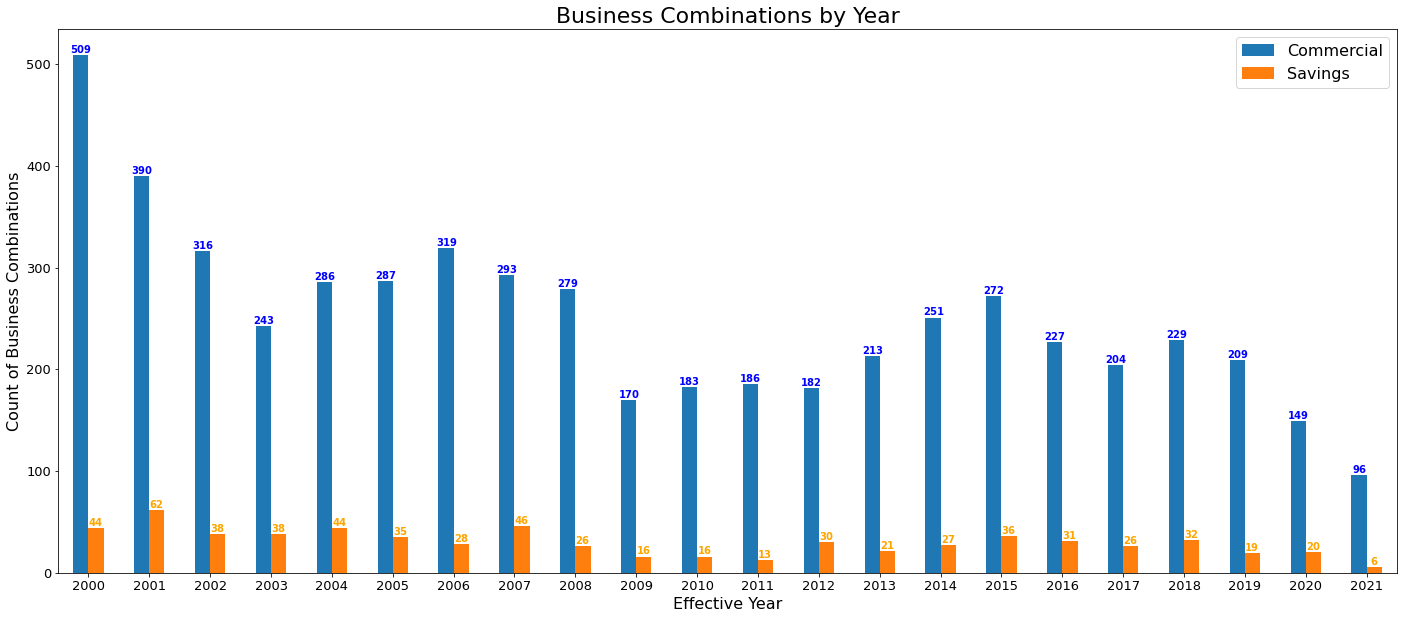

In [15]:
fig, axis = plt.subplots(figsize=(24, 10))

comb_by_year_reformat.plot(kind='bar', x='Effective Year', ax=axis)

axis.set_ylabel('Count of Business Combinations', size=16)
axis.set_xlabel('Effective Year', size=16)
axis.set_title('Business Combinations by Year', size=22)

axis.tick_params(axis='x', labelsize=13, labelrotation=0)
axis.tick_params(axis='y', labelsize=13)

axis.legend(fontsize=16)

for i, v in enumerate(comb_by_year_reformat['Commercial']):
    axis.text(i-0.12, v+2, str(v), color='blue', fontweight='bold', horizontalalignment='center')
for i, v in enumerate(comb_by_year_reformat['Savings']):
    axis.text(i+0.12, v+2, str(v), color='orange', fontweight='bold', horizontalalignment='center')

fig.show()

## Business Combinations - Failures

In [16]:
failures = pd.read_csv('../../data/Business_Combinations_-_Failures_10_21_2021.csv')

failures_clean = failures[['ACQ_CERT', 'ACQ_CLASS_TYPE_DESC', 'EFFDATE', 'PROCDATE']]
failures_clean['EFFDATE'] = pd.to_datetime(failures_clean['EFFDATE'])
failures_clean['PROCDATE'] = pd.to_datetime(failures_clean['PROCDATE'])

# n = 6
# failures.loc[(failures['ACQ_CLASS_TYPE_DESC'] == 'Savings') &
#                  (pd.DatetimeIndex(failures['EFFDATE']).year == 2009),
#                 failures.columns[n*10:(n+1)*10]
#                 ].reset_index(drop=True)


failures_clean

# FILTER -> 43
# FAILED_OTS_TO_OTS_FLAG -> 0         |  43  |  487
# FRM_CLASS_TYPE -> C                 |  43  |  426
# FRM_CLASS_TYPE_DESC -> Commercial   |  43  |  426
# OUT_CLASS_TYPE -> C                 |  43  |  426
# OUT_CLASS_TYPE_DESC -> Commercial   |  43  |  426

,ACQ_CERT,ACQ_CLASS_TYPE_DESC,EFFDATE,PROCDATE
0,35516,Commercial,2000-01-15,2000-02-01
1,8033,Commercial,2000-03-10,2000-03-13
2,19977,Commercial,2000-06-02,2000-06-06
3,57076,Commercial,2000-07-14,2000-07-20
4,15310,Commercial,2000-09-29,2000-10-02
...,...,...,...,...
568,16810,Commercial,2020-02-14,2020-02-18
569,34603,Commercial,2020-04-03,2020-04-06
570,50831,NaN,2014-05-24,2020-09-17
571,29566,Savings,2020-10-16,2020-10-20


In [17]:
comb_failures_by_year = failures_clean.groupby(['ACQ_CLASS_TYPE_DESC', pd.DatetimeIndex(failures_clean['EFFDATE']).year]).count()['ACQ_CERT'].reset_index()
comb_failures_by_year.columns = ['Class Type', 'Effective Year', 'Count']

comb_failures_by_year

,Class Type,Effective Year,Count
0,Commercial,2000,7
1,Commercial,2001,3
2,Commercial,2002,7
3,Commercial,2003,2
4,Commercial,2004,3
5,Commercial,2007,2
6,Commercial,2008,20
7,Commercial,2009,122
8,Commercial,2010,131
9,Commercial,2011,85


In [18]:
for year in range(2000, 2022):
    temp_com = comb_failures_by_year.loc[(comb_failures_by_year['Effective Year'] == year) &
                                         (comb_failures_by_year['Class Type'] == 'Commercial')]
    temp_sav = comb_failures_by_year.loc[(comb_failures_by_year['Effective Year'] == year) &
                                         (comb_failures_by_year['Class Type'] == 'Savings')]
    if len(temp_com) != 1:
        comb_failures_by_year = comb_failures_by_year.append({'Class Type': 'Commercial', 'Effective Year': year, 'Count': 0}, ignore_index=True)
    if len(temp_sav) != 1:
        comb_failures_by_year = comb_failures_by_year.append({'Class Type': 'Savings', 'Effective Year': year, 'Count': 0}, ignore_index=True)

comb_failures_by_year = comb_failures_by_year.sort_values(by=['Class Type', 'Effective Year']).reset_index(drop=True)

comb_failures_by_year_reformat = pd.DataFrame(comb_failures_by_year.loc[comb_failures_by_year['Class Type'] == 'Commercial', 'Effective Year'])
comb_failures_by_year_reformat['Commercial'] = list(comb_failures_by_year.loc[comb_failures_by_year['Class Type'] == 'Commercial', 'Count'])
comb_failures_by_year_reformat['Savings'] = list(comb_failures_by_year.loc[comb_failures_by_year['Class Type'] == 'Savings', 'Count'])
comb_failures_by_year_reformat

,Effective Year,Commercial,Savings
0,2000,7,0
1,2001,3,1
2,2002,7,0
3,2003,2,1
4,2004,3,0
5,2005,0,0
6,2006,0,0
7,2007,2,1
8,2008,20,4
9,2009,122,12


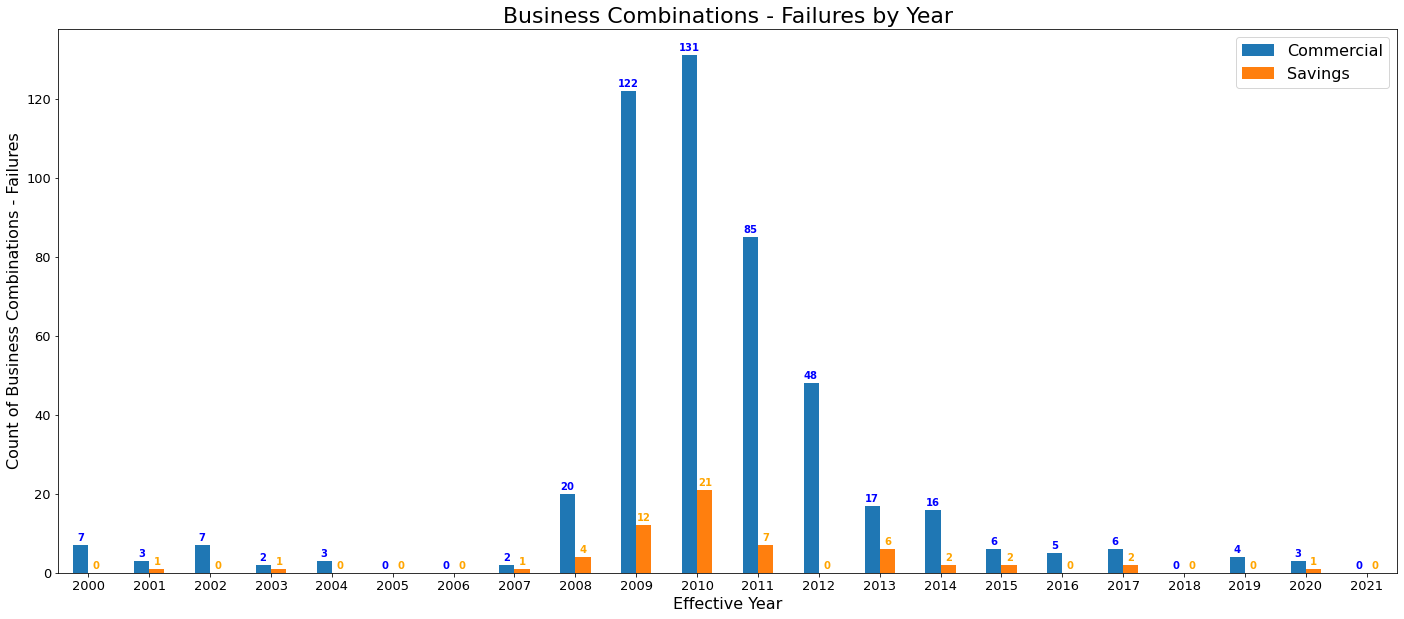

In [19]:
fig, axis = plt.subplots(figsize=(24, 10))

comb_failures_by_year_reformat.plot(kind='bar', x='Effective Year', ax=axis)

axis.set_ylabel('Count of Business Combinations - Failures', size=16)
axis.set_xlabel('Effective Year', size=16)
axis.set_title('Business Combinations - Failures by Year', size=22)

axis.tick_params(axis='x', labelsize=13, labelrotation=0)
axis.tick_params(axis='y', labelsize=13)

axis.legend(fontsize=16)

for i, v in enumerate(comb_failures_by_year_reformat['Commercial']):
    axis.text(i-0.13, v+1, str(v), color='blue', fontweight='bold', horizontalalignment='center')
for i, v in enumerate(comb_failures_by_year_reformat['Savings']):
    axis.text(i+0.13, v+1, str(v), color='orange', fontweight='bold', horizontalalignment='center')

fig.show()

## Summary Table - Commercial Banks

In [20]:
commercial_banks_sum = pd.read_csv('../../data/cb_structure.csv')
commercial_banks_sum = commercial_banks_sum[['YEAR', 'New_Char', 'MERGERS', 'UNASSIST', 'PAID_OFF', 'REL_CO', 'OTHER', 'TOTAL']]
commercial_banks_sum = commercial_banks_sum[commercial_banks_sum['YEAR'] >= 2000]

cb_terms = {'New_Char':'New Institutions',
            'MERGERS':'Mergers - Failure',
            'UNASSIST':'Mergers - NonFailure', 
            'PAID_OFF':'Failures Paid Off',
            'REL_CO':'Conversions',
            'OTHER':'Other Adjustments',
            'TOTAL':'Total'}
commercial_banks_sum = commercial_banks_sum.rename(columns=cb_terms)

commercial_banks_sum

,YEAR,New Institutions,Mergers - Failure,Mergers - NonFailure,Failures Paid Off,Conversions,Other Adjustments,Total
1,2000,190,7,509,0,471,431,8200
2,2001,127,3,390,0,405,369,7998
3,2002,91,7,316,4,311,268,7803
4,2003,110,2,243,0,233,223,7698
5,2004,122,3,286,0,249,224,7570
6,2005,167,0,287,0,234,219,7467
7,2006,179,0,319,0,255,239,7402
8,2007,176,2,293,0,309,297,7288
9,2008,91,20,279,0,274,251,7086
10,2009,29,122,170,6,233,228,6828


In [21]:
commercial_banks_calc = pd.DataFrame(comb_by_year_reformat['Effective Year'])
commercial_banks_calc['New Institutions'] = new_by_year_reformat['Commercial']
commercial_banks_calc['Mergers - Failure'] = comb_failures_by_year_reformat['Commercial']
commercial_banks_calc['Mergers - NonFailure'] = comb_by_year_reformat['Commercial']
commercial_banks_calc['Liquidations'] = liquidations_by_year_reformat['Commercial'] 

commercial_banks_calc[commercial_banks_calc['Effective Year'] <= 2020]

,Effective Year,New Institutions,Mergers - Failure,Mergers - NonFailure,Liquidations
0,2000,190,7,509,0
1,2001,127,3,390,0
2,2002,91,7,316,4
3,2003,110,2,243,0
4,2004,122,3,286,0
5,2005,167,0,287,0
6,2006,179,0,319,0
7,2007,176,2,293,0
8,2008,91,20,279,0
9,2009,29,122,170,6


## Summary Table - Savings Institutions

In [22]:
savings_institutions_sum = pd.read_csv('../../data/si_structure.csv')
savings_institutions_sum = savings_institutions_sum[['YEAR', 'newcount', 'chartoth', 'chrtrest', 'comboass', 'combos', 'tomerg', 'SAVINGS']]
savings_institutions_sum = savings_institutions_sum[savings_institutions_sum['YEAR'] >= 2000]

si_terms = {'newcount':'New Institutions',
            'chartoth':'Commercial Bank Transfers',
            'chrtrest':'Uninsured to Insured',
            'comboass':'Assisted Mergers with Thrifts',
            'combos':'Unassisted Mergers with Thrifts',
            'tomerg': 'Unassisted Mergers with CBS',
            'SAVINGS':'Total'}
savings_institutions_sum = savings_institutions_sum.rename(columns=si_terms)

savings_institutions_sum['Unassisted Mergers - Sum'] = savings_institutions_sum['Unassisted Mergers with Thrifts'] + \
                                                       savings_institutions_sum['Unassisted Mergers with CBS']

savings_institutions_sum


,YEAR,New Institutions,Commercial Bank Transfers,Uninsured to Insured,Assisted Mergers with Thrifts,Unassisted Mergers with Thrifts,Unassisted Mergers with CBS,Total,Unassisted Mergers - Sum
1,2000,30,4,45,0,28,8,1587,36
2,2001,16,3,57,1,32,11,1530,43
3,2002,1,2,10,0,28,8,1469,36
4,2003,5,2,14,0,24,13,1411,37
5,2004,5,2,6,0,30,14,1349,44
6,2005,12,2,2,0,20,14,1309,34
7,2006,14,1,2,0,15,12,1284,27
8,2007,9,4,8,1,22,20,1255,42
9,2008,4,6,2,1,16,9,1232,25
10,2009,1,0,0,5,11,5,1183,16


In [23]:
savings_institutions_calc = pd.DataFrame(comb_by_year_reformat['Effective Year'])
savings_institutions_calc['New Institutions'] = new_by_year_reformat['Savings']
savings_institutions_calc['Mergers - Failure'] = comb_failures_by_year_reformat['Savings']
savings_institutions_calc['Mergers - NonFailure'] = comb_by_year_reformat['Savings']
savings_institutions_calc['Liquidations'] = liquidations_by_year_reformat['Savings']   

savings_institutions_calc[savings_institutions_calc['Effective Year'] <= 2020]

# It all looks wrong
# Maybe a different date (doubtful)? Maybe a flag indicating if it's insured by FDIC (more likely)?
# Column names are also unintuitive, need better definitions

,Effective Year,New Institutions,Mergers - Failure,Mergers - NonFailure,Liquidations
0,2000,33,0,44,0
1,2001,18,1,62,0
2,2002,3,0,38,0
3,2003,7,1,38,0
4,2004,6,0,44,1
5,2005,14,0,35,0
6,2006,16,0,28,0
7,2007,17,1,46,0
8,2008,8,4,26,0
9,2009,8,12,16,1
